In [1]:
from DLtools.Data import instant_data,intersection,del_less_col,station_sel
from DLtools.evaluation_rec import real_eva_error,record_list_result
from DLtools.feature_sel import call_mar
from DLtools.MachineLearning import test_stationarity,tsplot

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# Load data

In [2]:
###### SETTING AREA ################
loading = instant_data()
# df,mode,n_past,n_future = loading.hourly_instant(),'hour',24*7,72
df,mode,n_past,n_future = loading.daily_instant(),'day',60,14

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
save_path = host_path
#######################################################
def scope_data(data):
    global start_p,stop_p
    return del_less_col(data[start_p:stop_p],0.8)
#######################################################
df_r = scope_data(loading.df_r)

* Filter ratio 80%, interpolation NaN

In [3]:
data = df[start_p:stop_p]
data = del_less_col(data,ratio=.80)
# data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)


Before del col are... 305
After... 251


In [4]:
df_rainST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-rain.csv')
df_waterST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-water-level.csv')
df_weatherST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-weather-data-master/station_metadata.csv')

* filter ST only avaliable 80% data

In [88]:
def clean_list(df_st,sel_word):
    global data
    data_col = list(data.columns)
    data_col = [i.split("_") for i in data_col]
    _col =list()
    if sel_word=='':
        for i in data_col:_col.append(i[0])
    else:
        for i in data_col:
            if i[1]==sel_word : _col.append(i[0])
    dis_loc = intersection(_col,list(df_st['code']))
    df_st = df_st.loc[df_st['code'].isin(dis_loc)]
    return df_st

In [89]:
df_rainST = clean_list(df_rainST,'rain')
df_waterST = clean_list(df_waterST,'wl')
df_weatherST = clean_list(df_weatherST,'')

In [93]:
df_rainST

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type,geometry
504,YOM002,เชียงม่วน,18.946189,100.258886,สระ,เชียงม่วน,พะเยา,แม่น้ำยม,ภาคเหนือ,W,POINT (100.25889 18.94619)
505,NAN002,ภูเพียง,18.859726,100.817126,เมืองจัง,ภูเพียง,น่าน,แม่น้ำน่าน,ภาคเหนือ,W,POINT (100.81713 18.85973)
506,YOM009,โพธิ์ประทับช้าง,16.310781,100.271763,โพธิ์ประทับช้าง,โพธิ์ประทับช้าง,พิจิตร,แม่น้ำยม,ภาคเหนือ,W,POINT (100.27176 16.31078)
508,WAN001,สามเงา,17.260589,99.077958,วังหมัน,สามเงา,ตาก,แม่น้ำวัง,ภาคเหนือ,W,POINT (99.07796 17.26059)
509,WAN003,เถิน,17.751757,99.230662,แม่ถอด,เถิน,ลำปาง,แม่น้ำวัง,ภาคเหนือ,W,POINT (99.23066 17.75176)
...,...,...,...,...,...,...,...,...,...,...,...
810,DNP002,หน่วยศึกษาการพัฒนาการอนุรักษ์ต้นน้ำน้ำงิม,19.340550,100.477180,ผาช้างน้อย,ปง,พะเยา,แม่น้ำยม,ภาคเหนือ,R,POINT (100.47718 19.34055)
811,DNP001,หน่วยศึกษาการพัฒนาการอนุรักษ์ต้นน้ำน้ำเงิน,19.363800,100.371000,ผาช้างน้อย,ปง,พะเยา,แม่น้ำยม,ภาคเหนือ,R,POINT (100.37100 19.36380)
813,DNP028,หน่วยศึกษาการพัฒนาการอนุรักษ์ต้นน้ำแม่หล่าย,18.120200,100.291000,สวนเขื่อน,เมืองแพร่,แพร่,แม่น้ำยม,ภาคเหนือ,R,POINT (100.29100 18.12020)
814,DNP023,หน่วยศึกษาการพัฒนาการอนุรักษ์ต้นน้ำแม่ตีบ,18.551210,99.996100,จางเหนือ,แม่เมาะ,ลำปาง,แม่น้ำยม,ภาคเหนือ,R,POINT (99.99610 18.55121)


In [79]:
CPY = df_waterST.loc[df_waterST['code']=='CPY012']

# Map display

In [80]:
import geopandas as gpd
path_w = "/home/song/Public/Song/Work/Thesis/data/map/TH_water/Wtr_body.shp"
path_t = '/home/song/Public/Song/Work/Thesis/data/map/Th_map/thailand.shp'
watermap = gpd.read_file(path_w)
thaimap = gpd.read_file(path_t)

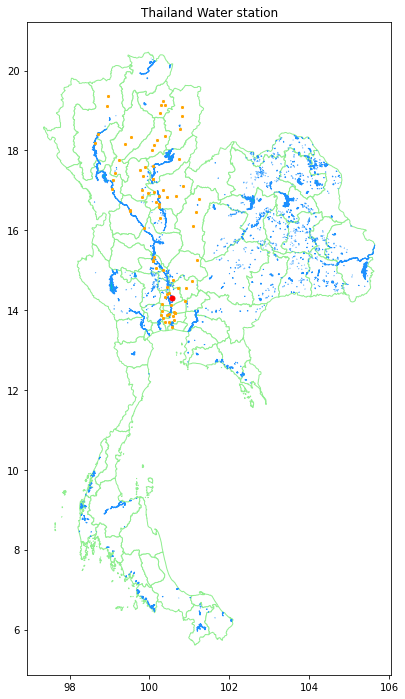

In [100]:
fig, ax = plt.subplots(1,figsize=(7,12))

thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue')
# #station map
station_map = gpd.GeoDataFrame(df_waterST, geometry=gpd.points_from_xy(df_waterST.long, df_waterST.lat))
CPY_station_map = gpd.GeoDataFrame(CPY, geometry=gpd.points_from_xy(CPY.long, CPY.lat))

ax.set_title('Thailand Water station')
station_map.plot(ax=ax, color='orange',marker="x",markersize=5)
CPY_station_map.plot(ax=ax, color='red',marker="o",markersize=25)
plt.savefig('watermap.png')

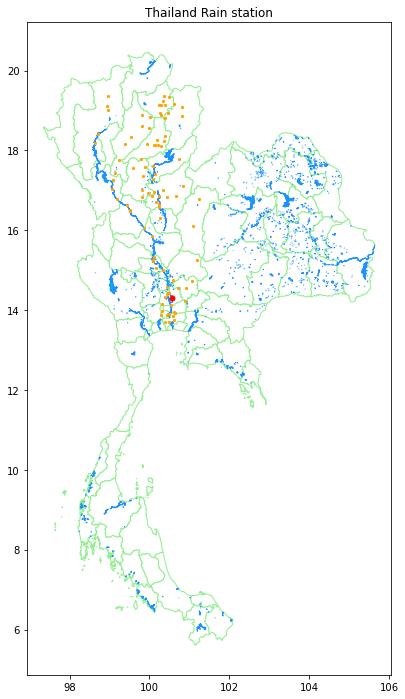

In [99]:
fig, ax = plt.subplots(1,figsize=(7,12))
thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue')
# station
rain_station_map = gpd.GeoDataFrame(df_rainST, geometry=gpd.points_from_xy(df_rainST.long, df_rainST.lat))

ax.set_title('Thailand Rain station')
rain_station_map.plot(ax=ax, color='orange',marker="x",markersize=5)
CPY_station_map.plot(ax=ax, color='red',marker="o",markersize=25)
plt.savefig('rainmap.png')

# Outlier detect

In [102]:
sns.boxplot(data=df_dam)

NameError: name 'df_dam' is not defined